In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

sns.set_style("whitegrid", {'axes.grid' : False})

from tqdm.auto import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import cv2
import imutils
import pickle

In [65]:
from utils.utils import open_video, crop_margins, map_frames, get_game_margins

In [7]:
screen_to_frame = pickle.load(open("data/screen_to_frame.p", "rb"))
# screen_to_frame = np.array([v.ravel() for v in screen_to_frame.values()])

In [ ]:
# check if all screens are present

fig, axs = plt.subplots(figsize=(16, 96))

for i, s in tqdm(enumerate(screen_to_frame.values())):
    plt.title(f"Screen {i}")
    plt.subplot(22, 2, i + 1)
    plt.imshow(s)

fig.tight_layout()

what am i going to present:

width 60 of every video

last screen corner case
detect not continuous video corner

find global position of game on screen
* calculate the number of unique pixels from the middle
* or KISS, detect the black line on top

time spent on each screen
* detect the screen using nearest neighbor
* get dictionary `{screen: [frames]}`
* for each screen calculate the proportion to the total time since start speedrun

heatmap of each screen
* detect the screen
* detect the kings location (relative to screen and absolute coordinates)
    * one shot object detection
    * opencv template matching
    * moving object detection (if does not move => previous location)
* produce heatmap

pipeline:
* map_screens.py and screen_to_frame.py for static files
* map_frames(filename, screen_to_frame)
* for each screen in screen to frames detect motion

https://www.sicara.ai/blog/en/object-detection-template-matching

https://debuggercafe.com/moving-object-detection-using-frame-differencing-with-opencv/

https://towardsdatascience.com/build-a-motion-heatmap-videousing-opencv-with-python-fd806e8a2340

https://github.com/kjw0612/awesome-deep-vision#imagenet-classification

-

https://www.pyimagesearch.com/2015/05/25/basic-motion-detection-and-tracking-with-python-and-opencv/

In [ ]:
screen_to_frame = pickle.load(open("data/screen_to_frame.p", "rb"))
screen_to_frame = np.array([v.ravel() for v in screen_to_frame.values()])

In [44]:
screen_to_frames, frame_to_screen = map_frames('data/speedrun_side.mp4', screen_to_frame)

getting video start


  0%|          | 0/11277 [00:00<?, ?it/s]

video starts at frame 325
mapping screens


  0%|          | 0/10952 [00:00<?, ?it/s]

done mapping screens


In [89]:
cap = open_video('data/speedrun_side.mp4')
margin_left, margin_right = get_game_margins(cap)
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

True

In [90]:
s = screen_to_frames[0][0]
n = s[1] - s[0]
cap.set(cv2.CAP_PROP_POS_FRAMES, s[0])

True

In [91]:
ret, frame = cap.read()
if ret == False:
    print("error")
    
frame = crop_margins(frame, margin_left, margin_right)
frame = imutils.resize(frame, width=60)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
first = frame

for i in tqdm(range(n-1)):
    ret, frame = cap.read()
    if ret == False:
        print("error")
        break
    frame = crop_margins(frame, margin_left, margin_right)
    frame = imutils.resize(frame, width=60)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frameDelta = cv2.absdiff(first, frame)
    cv2.imshow("CallingCamera View", frameDelta)
    k = cv2.waitKey(40) & 0xFF
    if k == ord('q'):
        break
        

cv2.destroyAllWindows()

  0%|          | 0/166 [00:00<?, ?it/s]

In [92]:
cap.release()

detect something like a box

if cannot => previous position

corner case first stage

In [93]:
king = cv2.imread('data/king.webp')

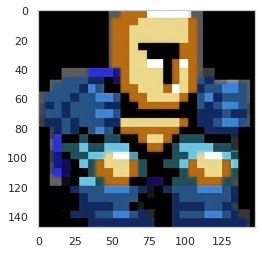

In [94]:
plt.imshow(king)

In [95]:
king.shape

(148, 148, 3)